In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datasketch import MinHash, MinHashLSH
import re


In [3]:
movie_path = os.path.abspath('../data/bronze/movies.csv')
rating_path = os.path.abspath('../data/bronze/ratings.csv')
df_movies_original = pd.read_csv(movie_path)
df_ratings_original = pd.read_csv(rating_path)

In [4]:
df_movies = df_movies_original.copy()
df_ratings = df_ratings_original.copy()

df_ratings.drop(columns=["timestamp"], inplace=True)
df_ratings = df_ratings.set_index("movieId", drop=False)

def extract_year(title: str):
    """Extracts year from parentheses at end of title and returns (clean_title, year or pd.NA)."""
    match = re.search(r"\((\d{4})\)", title)
    if match:
        year = int(match.group(1))
        clean_title = title[:match.start()].strip()
        return clean_title, year
    else:
        return title.strip(), pd.NA

# Apply extraction
df_movies[["title", "year"]] = df_movies["title"].apply(lambda x: pd.Series(extract_year(x)))

# ✅ Force to nullable integer dtype (keeps NaN-safe integers)
df_movies["year"] = df_movies["year"].astype("Int64")

# Split genres and set index
df_movies["genres"] = df_movies["genres"].apply(lambda g: g.split("|"))
df_movies = df_movies.set_index("movieId", drop=False)

In [5]:
movie_stats = (
    df_ratings_original
    .groupby("movieId")["rating"]
    .agg(["mean", "count", "std"])
    .rename(columns={"mean": "avg_rating", "count": "num_ratings"})
)

# Merge titles for readability
movie_stats = movie_stats.join(df_movies_original.set_index("movieId")["title"])


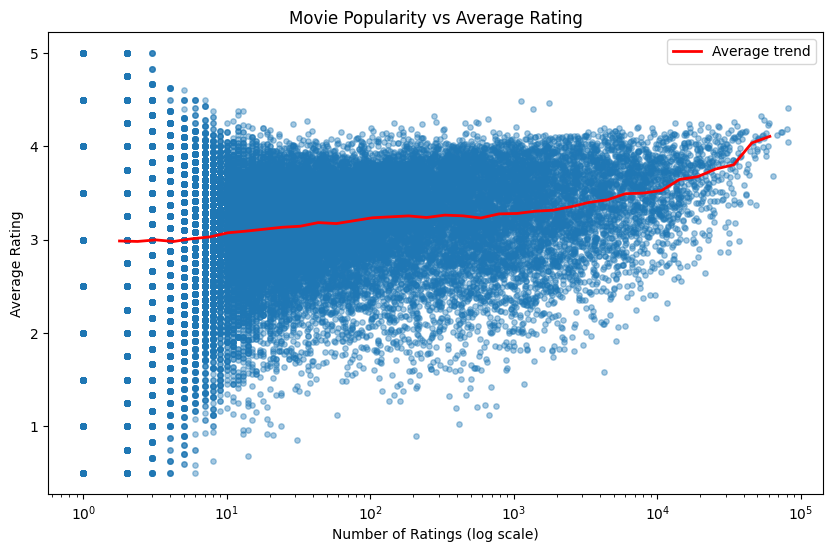

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(
    movie_stats["num_ratings"],
    movie_stats["avg_rating"],
    alpha=0.4,
    s=15
)

plt.xscale("log")
plt.xlabel("Number of Ratings (log scale)")
plt.ylabel("Average Rating")
plt.title("Movie Popularity vs Average Rating")

# Optional trend line (moving average / lowess)
from scipy.stats import binned_statistic

bins = np.logspace(0, np.log10(movie_stats["num_ratings"].max()), 40)
bin_means, _, _ = binned_statistic(
    movie_stats["num_ratings"], movie_stats["avg_rating"], statistic="mean", bins=bins
)
plt.plot(bins[:-1], bin_means, color="red", linewidth=2, label="Average trend")
plt.legend()
plt.show()


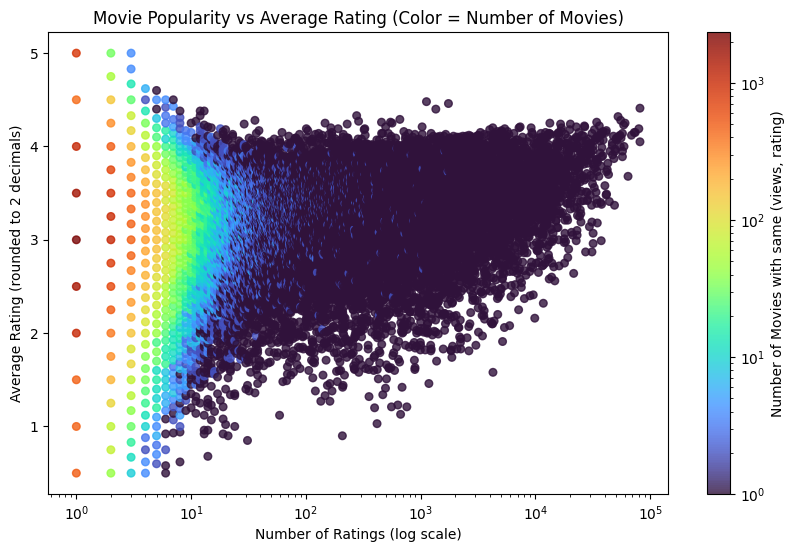

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Compute per-movie stats
movie_stats = (
    df_ratings_original
    .groupby("movieId")["rating"]
    .agg(["mean", "count"])
    .rename(columns={"mean": "avg_rating", "count": "num_ratings"})
)
movie_stats = movie_stats.join(df_movies_original.set_index("movieId")["title"])

# Round for grouping (to smooth floating noise)
movie_stats["avg_rating_rounded"] = movie_stats["avg_rating"].round(2)

# Aggregate identical (num_ratings, avg_rating) pairs
density = (
    movie_stats
    .groupby(["num_ratings", "avg_rating_rounded"])
    .size()
    .reset_index(name="movie_count")
)

# Plot with color intensity = frequency
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    density["num_ratings"],
    density["avg_rating_rounded"],
    c=density["movie_count"],
    cmap="turbo",            # or "plasma", "viridis", "hot"
    s=30,
    alpha=0.8,
    norm=plt.matplotlib.colors.LogNorm(),  # log color scaling for better contrast
)

plt.xscale("log")
plt.xlabel("Number of Ratings (log scale)")
plt.ylabel("Average Rating (rounded to 2 decimals)")
plt.title("Movie Popularity vs Average Rating (Color = Number of Movies)")

cb = plt.colorbar(sc)
cb.set_label("Number of Movies with same (views, rating)")
plt.show()
